In [ ]:
import pandas as pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def bayesian_adj_rating(df):
    min_votes = 30

    tmp_df = df.dropna(subset=['rating', 'num_votes'])

    tmp_df['w_rating'] = tmp_df['rating'] * tmp_df['num_votes'] / (tmp_df['num_votes'].sum())
    bayesian_weight = 4  # Bayesian 가중치 (조절 가능)
    tmp_df['b_rating'] = (
        (tmp_df['num_votes'] / (tmp_df['num_votes'] + min_votes)) * tmp_df['rating'] +
        (min_votes / (tmp_df['num_votes'] + min_votes)) * tmp_df['rating'].mean()
    )
    df = pd.merge(tmp_df[['wine_id', 'b_rating']], df, how='right', on='wine_id')

    return df

def get_item_data():
    data_path = "/home/dhkim/server_front/winery_server/data"
    data = pd.read_csv(os.path.join(data_path, "item_data.csv"))
    data = bayesian_adj_rating(data)
    # "grape"
    wine_column = ['wine_id','winetype','Red Fruit', 'Tropical', 'Tree Fruit', 'Oaky',\
        'Ageing', 'Black Fruit', 'Citrus', 'Dried Fruit', 'Earthy', 'Floral', \
        'Microbio','Spices', 'Vegetal', 'Light', 'Bold', 'Smooth', 'Tannic', 'Dry',\
        'Sweet', 'Soft', 'Acidic', 'Fizzy', 'Gentle','vintage','price',\
        'rating','b_rating', 'num_votes','country','region1','winery','name','wine_style','house',\
        'grape', 'pairing']

    # EX
    rename_rule = {
        'Red Fruit' : 'Red_Fruit',
        'Tree Fruit': 'Tree_Fruit',
        'Black Fruit':'Black_Fruit',
        'Dried Fruit':'Dried_Fruit',

    }

    df = data[wine_column]
    df = data.rename(columns=rename_rule)
    df.loc[df['vintage'].isna(), 'vintage'] = 0
    df[['grape','pairing']] = df[['grape','pairing']].astype(str)
    df['grape'] = df['grape'].copy().apply(lambda x: x.split() if x is not None else [])
    df['pairing'] = df['pairing'].copy().apply(lambda x: x.split() if x is not None else [])
    #df['winetype'].fillna(0, inplace=True)
    # for data in range(df.shape[0]):
    #     df['rating'][data] = float(df['rating'][data])
    return df

In [ ]:
df = get_item_data()

In [ ]:
top_300_df = df.groupby('wine_style', group_keys=False).apply(lambda group: group.nlargest(300, 'b_rating'))
# Reset index if needed
top_300_df.reset_index(drop=True, inplace=True)
# Display the resulting DataFrame
top_300_df.loc[:,['wine_style','b_rating','wine_id']]

In [ ]:
unique_wine_styles = df['wine_style'].unique()
unique_wine_styles

In [ ]:
def style_topK(df, style, K):
    if style != "Popular":
        filtered = df[df['wine_style'] == style]
    else:
        K = 100 
        filtered = df

    sorted_df = filtered.sort_values(by='b_rating', ascending=False)
    topK = sorted_df.head(K).loc[:, ['wine_id', 'name', 'rating','num_votes','b_rating']]
    return topK


In [ ]:
mbti_styles = [
    "Popular",
    "Portuguese Port",
    "French Champagne",
    "Spanish Cava",
    "Italian Moscato d'Asti",
    "Californian Chardonnay",
    "Californian Sauvignon Blanc",
    "Bordeaux White",
    "Bourgogne Chablis",
    "German Riesling",
    "New Zealand Sauvignon Blanc",
    "Californian Pinot Noir",
    "Californian Cabernet Sauvignon",
    "Californian Merlot",
    "Italian Barolo",
    "Italian Barbaresco",
    "Italian Brunello di Montalcino",
    "Italian Chianti",
    "Beaujolais Red",
    "Bordeaux Red",
    "Bourgogne Red",
    "Argentinian Malbec",
    "Australian Shiraz",
    "Spanish Rioja Red"
]


In [ ]:
df.columns

In [ ]:
taste = ['Light', 'Bold', 'Smooth', 'Tannic', 'Dry', 'Sweet', 'Soft', 'Acidic', 'Fizzy', 'Gentle']
note = ['Red_Fruit','Tropical', 'Tree_Fruit', 'Oaky', 'Ageing', 
     'Black_Fruit', 'Citrus','Dried_Fruit', 'Earthy', 'Floral', 
     'Microbio', 'Spices', 'Vegetal']

taste_related = ['Red_Fruit','Tropical', 'Tree_Fruit', 'Oaky', 'Ageing', 
     'Black_Fruit', 'Citrus','Dried_Fruit', 'Earthy', 'Floral', 
     'Microbio', 'Spices', 'Vegetal', 'Light', 'Bold', 'Smooth', 
     'Tannic', 'Dry', 'Sweet', 'Soft', 'Acidic','Fizzy', 'Gentle']

df['total'] = df.loc[:, taste].sum(axis = 1)
df = df[df['total'] != 0]

df['total'] = df.loc[:, note].sum(axis = 1)
df = df[df['total'] != 0]


In [ ]:
import numpy as np
for st in mbti_styles:
    st_df = df[df['wine_style'] == st].loc[:, taste_related + ['rating']]
    correlation_matrix = st_df.corr().loc[taste_related, ['rating']]
    
    plt.figure(figsize=(12, 8))
    plt.pcolor(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)  # 색상 맵 및 범위 설정
    plt.xticks(np.arange(0.5, len(correlation_matrix.columns), 1), correlation_matrix.columns, rotation='vertical')
    plt.yticks(np.arange(0.5, len(correlation_matrix.index), 1), correlation_matrix.index)
    plt.title('Heatmap by plt.pcolor()', fontsize=20)

    plt.title(f'{st} Heatmap')
    plt.show()
    plt.savefig(f'/home/dhkim/server_front/{st}.png')

In [ ]:
styletopK = {}
for style in mbti_styles:
    styletopK[style] = list(style_topK(df, style, 500)['wine_id'])

In [ ]:
import json
with open('/home/dhkim/server_front/winery_server/data/styletopK.json', 'w') as json_file:
    json.dump(styletopK, json_file)

In [ ]:
 ['a1', 'b3', 'c2', 'd3', 'e2'],

In [ ]:
import numpy as np
for st in mbti_styles:
    st_df = df[df['wine_style'] == st].loc[:, taste_related + ['rating']]

In [ ]:
grouped_df = df.groupby('wine_style')[taste_related + ['rating']].mean().replace(0, np.nan)

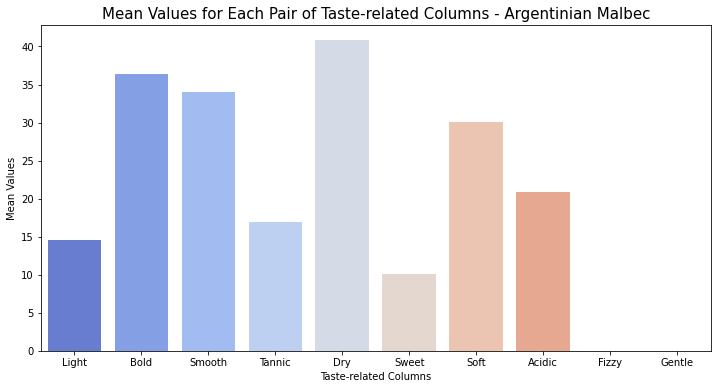

<Figure size 432x288 with 0 Axes>

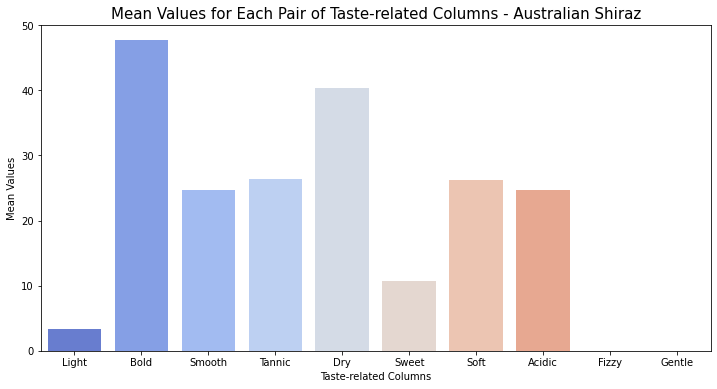

<Figure size 432x288 with 0 Axes>

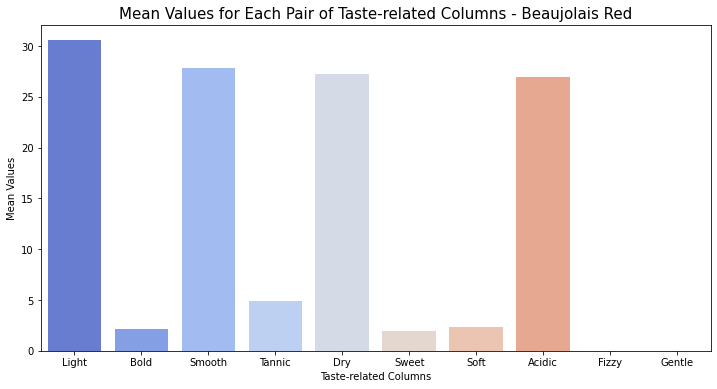

<Figure size 432x288 with 0 Axes>

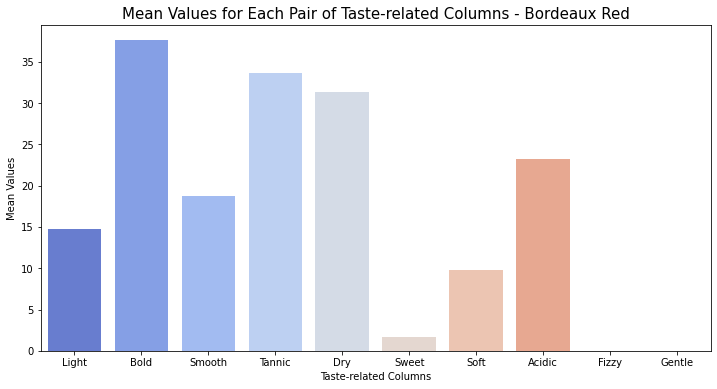

<Figure size 432x288 with 0 Axes>

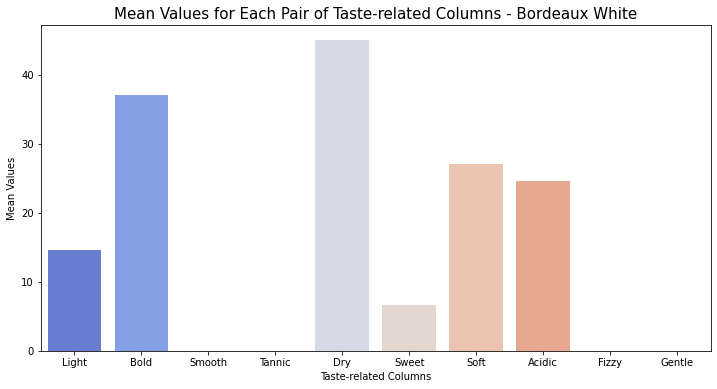

<Figure size 432x288 with 0 Axes>

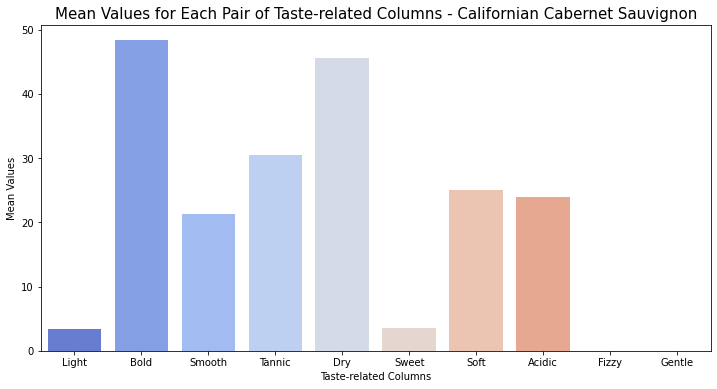

<Figure size 432x288 with 0 Axes>

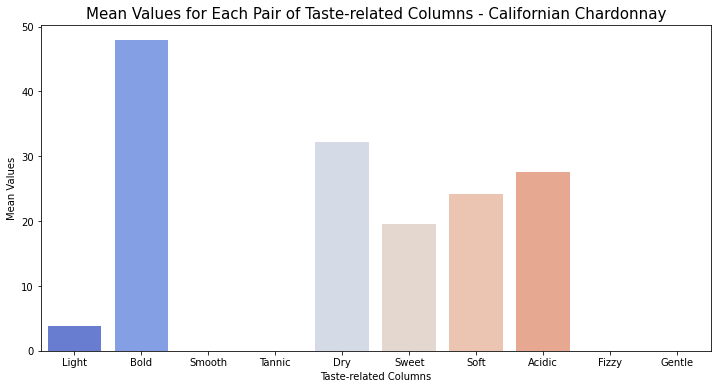

<Figure size 432x288 with 0 Axes>

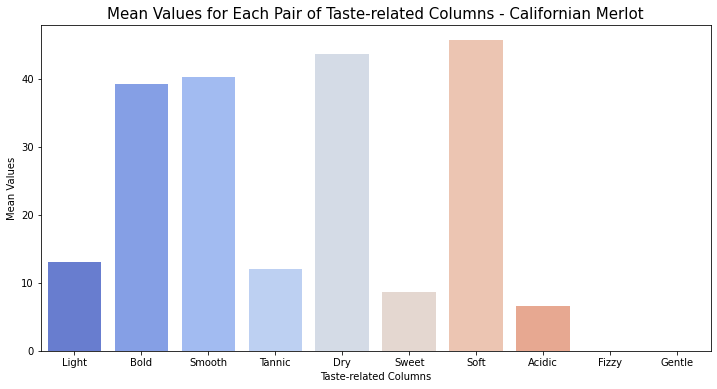

<Figure size 432x288 with 0 Axes>

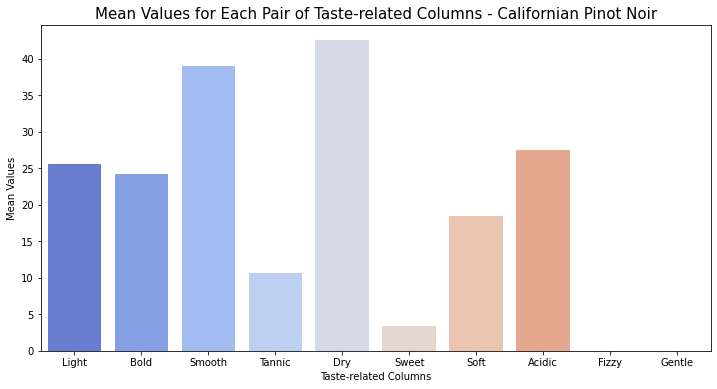

<Figure size 432x288 with 0 Axes>

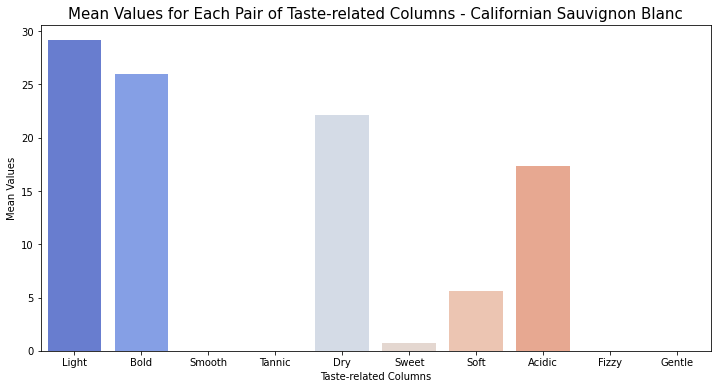

<Figure size 432x288 with 0 Axes>

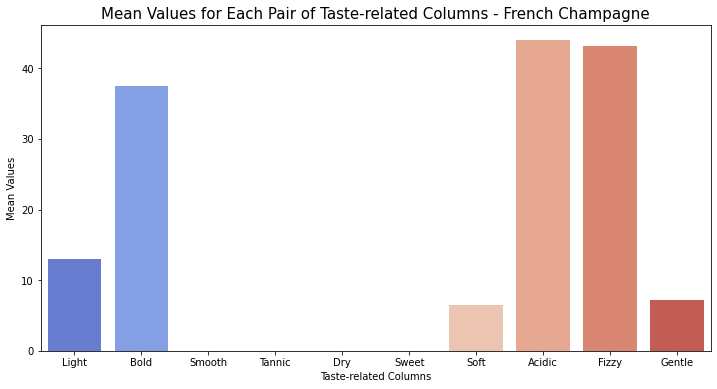

<Figure size 432x288 with 0 Axes>

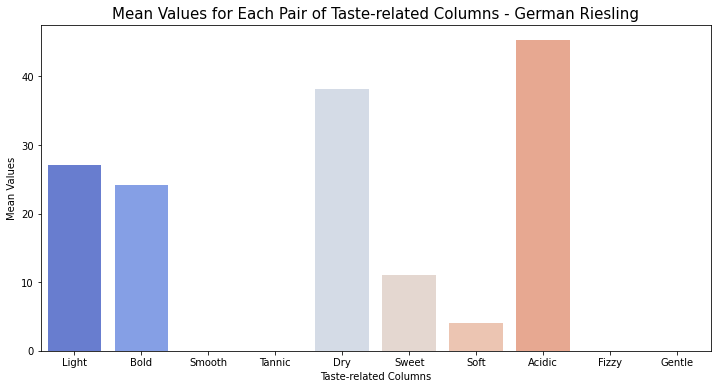

<Figure size 432x288 with 0 Axes>

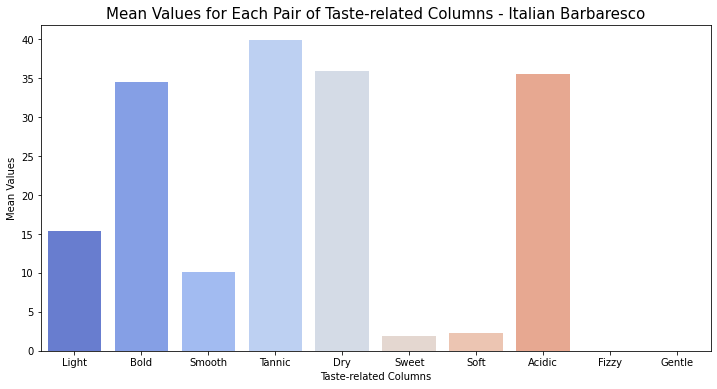

<Figure size 432x288 with 0 Axes>

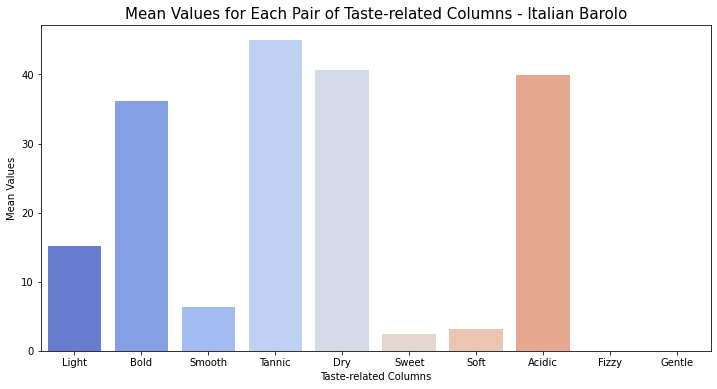

<Figure size 432x288 with 0 Axes>

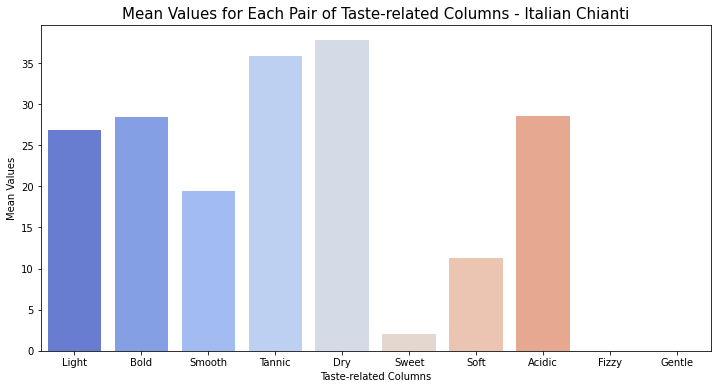

<Figure size 432x288 with 0 Axes>

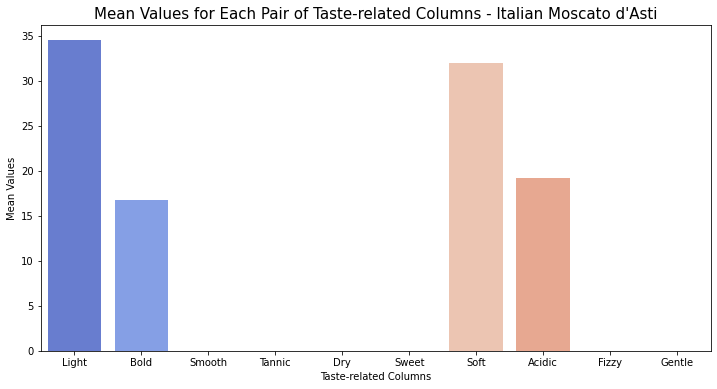

<Figure size 432x288 with 0 Axes>

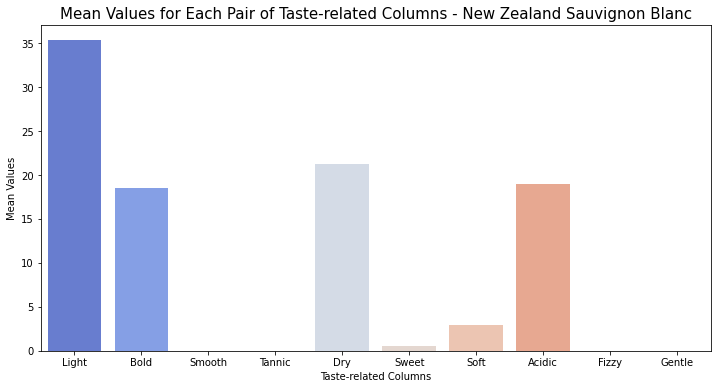

<Figure size 432x288 with 0 Axes>

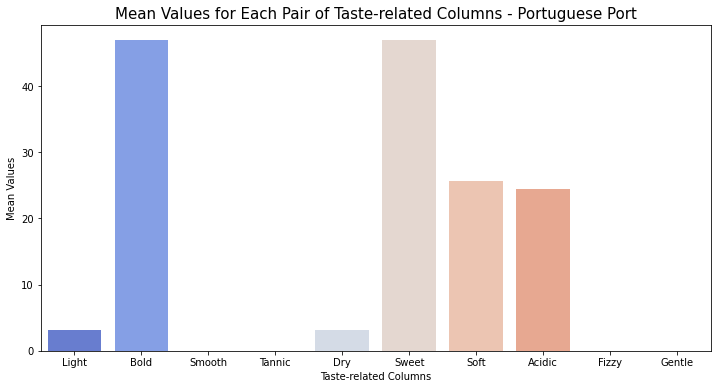

<Figure size 432x288 with 0 Axes>

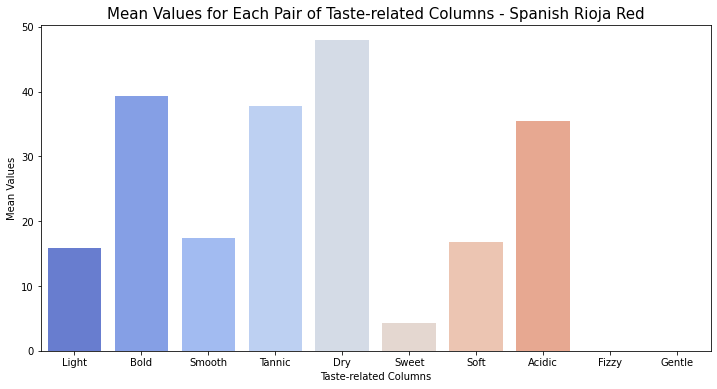

<Figure size 432x288 with 0 Axes>

In [35]:
for index, row in grouped_df.loc[:,taste].iterrows():
    if index in mbti_styles:
        plt.figure(figsize=(12, 6))
        sns.barplot(x=taste, y=row[taste], palette='coolwarm')
        plt.title(f'Mean Values for Each Pair of Taste-related Columns - {index}', fontsize=15)
        plt.xlabel('Taste-related Columns')
        plt.ylabel('Mean Values')
        plt.show()
        plt.savefig(f'{index}.png', transparent=True)